# Notebook 4. Regress Next Month.

Essentially, this notebook implements Context-Based Series Prediction. 

In [1]:
from typing import List
from typing import Any
from typing import Callable
from typing import Union
from typing import Tuple
from typing import Dict
from typing import Optional

import os
import copy
from collections import OrderedDict
from collections import defaultdict
import pickle

import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk
import matplotlib.pyplot as plt

%matplotlib inline
RANDOM_SEED: int = 42
np.random.seed(RANDOM_SEED)
EstimatorType: Union = Union[sk.base.BaseEstimator, Any]

Reading previously dumped data:

In [2]:
class DataTable: pass
train_table: DataTable = joblib.load("prepared_data/train_data.jbl")
test_table: DataTable = joblib.load("prepared_data/test_data.jbl")

if not os.path.exists("images/regress"):
    os.makedirs("images/regress")

## Metrics

MetricHolder is an entity for storing the experiment results.

In [21]:
class MetricHolder:
    """ Contains the summary of the algorithm evaluation.
    Also responsible for exporting this summary to Pandas,
    LaTeX or Excel.
    
    
    Attributes:
        name -- Name of the holder.
        storage -- Storage, mapping key to a list of values. 
            Essentially, maps algorithm title to a list of 
            algorithm names, and maps metric names to the 
            corresponding lists of metric values.
        algo2estimator -- Maps algorithm name to the fitted
            estimator.
    """
    def __init__(self, holder_name: str) -> None:
        """ Initializer method.
        
        Arguments:
            holder name -- Name of the holder.
        """
        self.name: str = holder_name
        self.storage: Dict[str, List[Any]] = defaultdict(list)
        self.algo2estimator: Dict[str, EstimatorType] = dict()
        
    def commit(self, algo_name: str, algo_performance: Dict[str, float], 
               best_estimator: EstimatorType) -> None:
        """ Adds new estimator and its performance to the data
        structure.
        
        Arguments:
            algo_name -- Name of the algorithm.
            algo_performance -- Map from metric name to its value.
            best_estimator -- The best estimator among the learned
                instances of the algorithm.
        """
        name_tokens: List[str] = algo_name.strip().split("_")
        title_tokens: List[str] = [item.capitalize() for item in name_tokens]
        algo_title: str = " ".join(title_tokens[:-2])
        target_title: str = " ".join(title_tokens[-2:])
        if algo_name == "baseline":
            algo_title = "Baseline"
            target_title = "Id Exact"
        self.storage['Algorithm'].append(algo_title)
        self.storage['Target Form'].append(target_title)
        self.algo2estimator[algo_name] = best_estimator
        
        metric: str; value: float
        for metric, value in algo_performance.items():
            self.storage[metric].append(value)
            
    def make_table(self) -> pd.DataFrame:
        """ Export state summary into a table.
        
        Returns:
            Pandas dataframe with state summary.
        """
        return pd.DataFrame.from_dict(self.storage)
    
    def create_table_folder(self) -> None:
        """ Creates folder for storing tables if needed."""
        if not os.path.exists("tables/"):
            os.makedirs("tables/")
    
    def export_to_csv(self) -> None:
        """ Exports summary to CSV. The location
        is tables/<holder_name>.csv
        """
        table: pd.DataFrame = self.make_table()
        self.create_table_folder()
        table.to_csv("tables/" + self.name + ".csv")
    
    def export_to_tex(self) -> None:
        """ Exports summary to Latex. The location
        is tables/<holder_name>.tex"""
        table: pd.DataFrame = self.make_table()
        self.create_table_folder()
        table.to_latex("tables/" + self.name + ".tex",  float_format="%.2f")
        
    def export_to_xlsx(self) -> None:
        """ Exports summary to excel. The location
        is tables/<holder_name>.xlsx"""
        table: pd.DataFrame = self.make_table()
        self.create_table_folder()
        table.to_excel("tables/" + self.name + ".xlsx", float_format="%.2f")

This work will use two metric holders. Value metrics are metrics computed for real values, and Percent metrics are metrics computed for relative values.

In [4]:
value_prediction_metrics: MetricHolder = MetricHolder("value_prediction_metrics") 
percent_prediction_metrics: MetricHolder = MetricHolder("percent_prediction_metrics")

Routines below simplify computation of metrics after true values and predicted values are provided.

In [5]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, max_error, explained_variance_score

def root_mean_squared_error(y_true: Union[List[float], np.array], 
                            y_pred: Union[List[float], np.array]) -> float:
    """ Computes RMSE metric.
    
    Arguments:
        y_true -- Reference values.
        y_pred -- Predicted values.
    
    Returns:
        Metric value.
    """
    return mean_squared_error(y_true, y_pred, squared=False)
    

def compute_metrics(y_true: Union[List[float], np.array], 
                    y_pred: Union[List[float], np.array]) -> Dict[str, float]:
    """ Computes relevant metrics and returns a structure with them.
    
    Arguments:
        y_true -- Reference values.
        y_pred -- Predicted values.
        
    Returns:
        Map from metric name to its value.
    """
    metric_info: Dict[str, float] = dict()
    name: str; metric: Callable[[Union[List[float], np.array], Union[List[float], np.array]], float]
    for name, metric in zip(["MAE", "RMSE", "MAXERR", "EXPVAR"], [
                mean_absolute_error, root_mean_squared_error, max_error, explained_variance_score]):
        metric_info[name] = metric(y_true, y_pred)
    return metric_info


## Baseline: Return Scheduled

For a baseline, we assume that the client repays exactly the scheduled amount.

In [6]:
exact_baseline_score: Dict[str, float] = compute_metrics(
    test_table.matrix['REPAYMENT_ACTUAL'], test_table.matrix['REPAYMENT_SCHEDULED'])
percent_baseline_score: Dict[str, float] = compute_metrics(
    test_table.matrix['PERCENT_ACTUAL'], test_table.matrix['RELATIVE_REPAYMENT_SCHEDULED'])

value_prediction_metrics.commit("baseline", exact_baseline_score, None)
percent_prediction_metrics.commit("baseline", percent_baseline_score, None)

## General Precomputations

In [7]:
y_train_id_exact: pd.Series = copy.deepcopy(train_table.matrix[train_table.id_target_exact_key])
y_train_log_exact: pd.Series = copy.deepcopy(train_table.matrix[train_table.log_target_exact_key])
y_train_id_relative: pd.Series = copy.deepcopy(train_table.matrix[train_table.id_target_relative_key])
y_train_log_relative: pd.Series = copy.deepcopy(train_table.matrix[train_table.log_target_relative_key])

X_train: pd.DataFrame = copy.deepcopy(train_table.matrix).drop(train_table.explicit_target_keys + ['CONTRACT_ID'], axis=1)

y_test_id_exact: pd.Series = copy.deepcopy(test_table.matrix[test_table.id_target_exact_key])
y_test_log_exact: pd.Series = copy.deepcopy(test_table.matrix[test_table.log_target_exact_key])
y_test_id_relative: pd.Series = copy.deepcopy(test_table.matrix[test_table.id_target_relative_key])
y_test_log_relative: pd.Series = copy.deepcopy(test_table.matrix[test_table.log_target_relative_key])

X_test: pd.DataFrame = copy.deepcopy(test_table.matrix).drop(test_table.explicit_target_keys + ['CONTRACT_ID'], axis=1)

DatasetInfo is an entity to hold all data-related fields.

In [8]:
class DatasetInfo:
    """ Stores training and testing information for all 
    settings (id/log/relative/exact).
    
    Attributes:
        X_train -- Train set features.
        X_test -- Test set features.
        y_test_id_exact -- Test set id exact target.
        y_test_id_relative -- Test set id relative target.
        y_train_id_exact -- Train set id exact target.
        y_train_log_exact -- Train set log exact target.
        y_train_id_relative -- Train set id relative target.
        y_train_log_relative -- Train set log relative target.
    """
    def __init__(self, X_train: pd.DataFrame, X_test: pd.DataFrame,
                y_train_id_exact: pd.Series, y_train_id_relative: pd.Series,
                y_train_log_exact: pd.Series, y_train_log_relative: pd.Series,
                y_test_id_exact: pd.Series, y_test_id_relative: pd.Series) -> None:
        self.X_train: pd.DataFrame = X_train
        self.X_test: pd.DataFrame = X_test
        self.y_test_id_exact: pd.Series = y_test_id_exact
        self.y_test_id_relative: pd.Series = y_test_id_relative
        self.y_train_id_exact: pd.Series = y_train_id_exact
        self.y_train_id_relative: pd.Series = y_train_id_relative
        self.y_train_log_exact: pd.Series = y_train_log_exact
        self.y_train_log_relative: pd.Series = y_train_log_relative

In [9]:
dataset_info: DatasetInfo = DatasetInfo(X_train, X_test, y_train_id_exact, y_train_id_relative,
                                       y_train_log_exact, y_train_log_relative,
                                       y_test_id_exact, y_test_id_relative)

The routine below performs grid search in all settings (id-exact, id-relative, log-exact, log-relative) and adds corresponding summary information to holders (value-prediction-metrics and percent-prediction-metrics).

In [10]:
def perform_grid_search(estimator: EstimatorType, 
                        param_grid: Dict[str, List[Any]], 
                        experiment_name: str,
                        value_prediction_metrics: MetricHolder,
                        percent_prediction_metrics: MetricHolder,
                        ds_info: DatasetInfo) -> None:
    """ Implements Grid Search in ID-EXACT, ID-RELATIVE, 
    LOG-EXACT and LOG-RELATIVE settings subject to specified
    estimator type and parameter grid.
    
    Arguments:
        estimator: Estimator to fit.
        param_grid: Parameter Grid for GridSearchCV.
        experiment_name: Title of the algorithm.
        value_prediction_metrics: Holder for exact metrics.
        percent_prediction_metrics: Holder for relative metrics.
        ds_info: Dataset information.
    """
    cv_est: EstimatorType = GridSearchCV(estimator, param_grid, cv=3)
    
    # Exact prediction.
    cv_est.fit(ds_info.X_train, ds_info.y_train_id_exact)
    y_pred: Union[List[float], np.array] = cv_est.predict(ds_info.X_test)
    value_prediction_metrics.commit(
        experiment_name + "_id_exact",
        compute_metrics(ds_info.y_test_id_exact, y_pred),
        cv_est.best_estimator_)
    percent_prediction_metrics.commit(
        experiment_name + "_id_exact",
        compute_metrics(ds_info.y_test_id_relative, y_pred / ds_info.X_test['CONTRACT_SUM'] * 100),
        cv_est.best_estimator_)
    
    # Log-Exact prediction.
    cv_est.fit(ds_info.X_train, ds_info.y_train_log_exact)
    y_pred = np.expm1(cv_est.predict(ds_info.X_test))
    value_prediction_metrics.commit(
        experiment_name + "_log_exact",
        compute_metrics(ds_info.y_test_id_exact, y_pred),
        cv_est.best_estimator_)
    percent_prediction_metrics.commit(
        experiment_name + "_log_exact",
        compute_metrics(ds_info.y_test_id_relative, y_pred / ds_info.X_test['CONTRACT_SUM'] * 100),
        cv_est.best_estimator_)
    
    # Relative prediction.
    cv_est.fit(ds_info.X_train, ds_info.y_train_id_relative)
    y_pred = cv_est.predict(ds_info.X_test) * ds_info.X_test['CONTRACT_SUM'] / 100
    value_prediction_metrics.commit(
        experiment_name + "_id_relative",
        compute_metrics(ds_info.y_test_id_exact, y_pred),
        cv_est.best_estimator_)
    percent_prediction_metrics.commit(
        experiment_name + "_id_relative",
        compute_metrics(ds_info.y_test_id_relative, y_pred / ds_info.X_test['CONTRACT_SUM'] * 100),
        cv_est.best_estimator_)
    
    # Log-Relative prediction.
    cv_est.fit(ds_info.X_train, ds_info.y_train_log_relative)
    y_pred = np.expm1(cv_est.predict(ds_info.X_test)) * ds_info.X_test['CONTRACT_SUM'] / 100
    value_prediction_metrics.commit(
        experiment_name + "_log_relative",
        compute_metrics(ds_info.y_test_id_exact, y_pred),
        cv_est.best_estimator_)
    percent_prediction_metrics.commit(
        experiment_name + "_log_relative",
        compute_metrics(ds_info.y_test_id_relative, y_pred / ds_info.X_test['CONTRACT_SUM'] * 100),
        cv_est.best_estimator_)

## 1. Linear Models

Begin with ridge regression.

In [11]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

ridge_grid: Dict[str, List[Any]] = {
    'alpha': [0.01, 0.01, 0.1, 0.5, 1.0, 10.0, 20.0]
}
ridge_est: EstimatorType = Ridge(alpha=0.1)
perform_grid_search(ridge_est, ridge_grid, 'ridge_regression', 
                    value_prediction_metrics, percent_prediction_metrics, dataset_info)

Lasso Regression.

In [12]:
from sklearn.linear_model import Lasso
lasso_est: EstimatorType = Lasso(alpha=0.1, max_iter=10000)
lasso_grid: Dict[str, List[Any]] = {
    'alpha' : [0.01, 0.1, 1.0, 10.0, 20.0]   
}
perform_grid_search(lasso_est, lasso_grid, 'lasso_regression', 
                    value_prediction_metrics, percent_prediction_metrics, dataset_info)

C:\Users\nekrald\anaconda3\envs\comm-461\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.942e+07, tolerance: 2.127e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\nekrald\anaconda3\envs\comm-461\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.773e+07, tolerance: 2.222e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\nekrald\anaconda3\envs\comm-461\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing 

Bayesian Ridge Regression.

In [13]:
from sklearn.linear_model import BayesianRidge
est_bayesian: EstimatorType = BayesianRidge(n_iter=400)
bayesian_grid: Dict[str, List[Any]] = {
    'n_iter': [400, 500, 600],
}
perform_grid_search(est_bayesian, bayesian_grid, 'bayesian_regression', 
                    value_prediction_metrics, percent_prediction_metrics, dataset_info)

C:\Users\nekrald\anaconda3\envs\comm-461\Lib\site-packages\sklearn\linear_model\_bayes.py:53: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.3 and will be removed in 1.5
  warnings.warn(
C:\Users\nekrald\anaconda3\envs\comm-461\Lib\site-packages\sklearn\linear_model\_bayes.py:53: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.3 and will be removed in 1.5
  warnings.warn(
C:\Users\nekrald\anaconda3\envs\comm-461\Lib\site-packages\sklearn\linear_model\_bayes.py:53: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.3 and will be removed in 1.5
  warnings.warn(
C:\Users\nekrald\anaconda3\envs\comm-461\Lib\site-packages\sklearn\linear_model\_bayes.py:53: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.3 and will be removed in 1.5
  warnings.warn(
C:\Users\nekrald\anaconda3\envs\comm-461\Lib\site-packages\sklearn\linear_model\_bayes.py:53: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.3 and will be removed in 1.5
  

# 2. Tree-Based Ensemble Models

Random Forest

In [14]:
from sklearn.ensemble import RandomForestRegressor
rf_param_grid: Dict[str, List[Any]] = {
    'n_estimators' : [100],
    'max_depth': [10, 20, 30],
    'min_samples_leaf': [5, 10]
}
est_rf: EstimatorType = RandomForestRegressor(n_jobs=-1)
perform_grid_search(est_rf, rf_param_grid, "random_forest", 
                    value_prediction_metrics, percent_prediction_metrics, dataset_info)

XGBoost

In [16]:
import xgboost
xgboost_params: Dict[str, List[Any]] = {
    'learning_rate': [0.01],
    'max_depth': [10, 30],
    'n_estimators': [100],
    'reg_alpha': [0.05],
    'reg_lambda': [0.45],
    'booster': ['gbtree', 'dart'],
}
xgb_model: EstimatorType = xgboost.XGBRegressor(               
    learning_rate=0.01, max_depth=4, n_estimators=500,                                                                    
    reg_alpha=0.5, reg_lambda=0.45, seed=42, n_jobs=12)
perform_grid_search(xgb_model, xgboost_params, "xgboost", 
                    value_prediction_metrics, percent_prediction_metrics, dataset_info)

## 3. Sklearn MLP Regressor

In [17]:
from sklearn.neural_network import MLPRegressor
nn_params: Dict[str, List[Any]] = {
    'hidden_layer_sizes':  [(128), (64), (32, 32)],
    'alpha' : [0.01]
}
nn_est: EstimatorType = MLPRegressor(max_iter=10000)
perform_grid_search(nn_est, nn_params, "sklearn_neural_net", 
                    value_prediction_metrics, percent_prediction_metrics, dataset_info)

## 4. Support Vector Regression

In [18]:
from sklearn.svm import SVR
svr_est: EstimatorType = SVR(C=10.0, gamma='auto')
svr_params: Dict[str, List[Any]] = {
    "C": [5.0],
    "gamma": ['scale'],
    "cache_size": [15000],
    "max_iter": [5000]
}
perform_grid_search(svr_est, svr_params, "svr", 
                    value_prediction_metrics, percent_prediction_metrics, dataset_info)

C:\Users\nekrald\anaconda3\envs\comm-461\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\nekrald\anaconda3\envs\comm-461\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\nekrald\anaconda3\envs\comm-461\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\nekrald\anaconda3\envs\comm-461\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\nekrald\anaconda3\envs\comm-461\Lib\site-packages\s

# 5. KNN

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline

knn_params: Dict[str, List[Any]] = {'knn__n_neighbors': [5, 10, 15]}
knn_model: EstimatorType = Pipeline(steps= [('scaler', StandardScaler()), ('knn', KNeighborsRegressor(n_jobs=-1))])

perform_grid_search(knn_model, knn_params, 'knn_regressor', 
                    value_prediction_metrics, percent_prediction_metrics, dataset_info)

C:\Users\nekrald\anaconda3\envs\comm-461\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\nekrald\anaconda3\envs\comm-461\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


Now look into value-prediction-metrics and export them to files.

In [24]:
value_prediction_metrics.export_to_tex()
value_prediction_metrics.export_to_csv()
value_prediction_metrics.export_to_xlsx()
value_prediction_metrics.make_table()

,Algorithm,Target Form,MAE,RMSE,MAXERR,EXPVAR
0,Baseline,Id Exact,26.380093,98.946429,1947.340000,0.012502
1,Ridge Regression,Id Exact,29.456582,93.351410,1868.693613,0.074753
2,Ridge Regression,Log Exact,22.909395,95.124187,1897.793936,0.065941
3,Ridge Regression,Id Relative,30.015263,93.200889,1841.279978,0.077639
4,Ridge Regression,Log Relative,22.530081,94.090354,1881.302136,0.076451
5,Lasso Regression,Id Exact,29.607689,93.495187,1870.545178,0.071958
6,Lasso Regression,Log Exact,23.234320,95.515119,1904.224612,0.060125
7,Lasso Regression,Id Relative,29.956426,93.240653,1848.465875,0.076894
8,Lasso Regression,Log Relative,22.959399,94.435634,1892.134011,0.070706
9,Bayesian Regression,Id Exact,29.503355,93.420754,1869.655299,0.073405


Look into percent-prediction-metrics and export them to files.

In [25]:
percent_prediction_metrics.export_to_csv()
percent_prediction_metrics.export_to_tex()
percent_prediction_metrics.export_to_xlsx()
percent_prediction_metrics.make_table()

,Algorithm,Target Form,MAE,RMSE,MAXERR,EXPVAR
0,Baseline,Id Exact,2.314208,7.711478,99.173700,0.032126
1,Ridge Regression,Id Exact,2.466424,7.086186,99.238850,0.130671
2,Ridge Regression,Log Exact,1.934580,7.278801,98.964112,0.113608
3,Ridge Regression,Id Relative,2.476365,7.080060,99.417530,0.132117
4,Ridge Regression,Log Relative,1.898504,7.190695,99.022478,0.124736
5,Lasso Regression,Id Exact,2.481021,7.095173,99.292145,0.128541
6,Lasso Regression,Log Exact,1.987902,7.311317,98.866378,0.107712
7,Lasso Regression,Id Relative,2.479758,7.083935,99.233937,0.131209
8,Lasso Regression,Log Relative,1.945049,7.231323,98.776129,0.116874
9,Bayesian Regression,Id Exact,2.474962,7.092681,99.198278,0.129112


Random Forest log-relative shows the best MAE performance.

# Algorithm-based Visualizations

1. Visualization of Lasso coefficients.
2. Visualization of Ridge coefficients.
3. Feature importances in Random Forest.
4. Feature importances in xgboost.


Begin with some data management.

In [26]:
all_dropna_table: DataTable = joblib.load("prepared_data/all_data_dropped_na.jbl")

y_all_id_exact: pd.Series = copy.deepcopy(
    all_dropna_table.matrix[all_dropna_table.id_target_exact_key])
y_all_log_exact: pd.Series = copy.deepcopy(
    all_dropna_table.matrix[all_dropna_table.log_target_exact_key])
y_all_id_relative: pd.Series = copy.deepcopy(
    all_dropna_table.matrix[all_dropna_table.id_target_relative_key])
y_all_log_relative: pd.Series = copy.deepcopy(
    all_dropna_table.matrix[all_dropna_table.log_target_relative_key])

X_all: pd.DataFrame = copy.deepcopy(all_dropna_table.matrix).drop(
    all_dropna_table.explicit_target_keys + ['CONTRACT_ID'], axis=1)

Introduce routine for plotting linear coefficients.

In [27]:
import seaborn as sns

def plot_linear_coefficients(X_train: pd.DataFrame, linear_model: EstimatorType, 
                             title: str, shrink: Optional[float]=None, x_figure_shift: int=0) -> None:
    """ Performs visualization of linear model coefficients.
    The result is saved to the images/regress directory.
    
    Arguments:
        X_train -- Train dataframe.
        linear_model -- Estimator, assumed to contain linear model with attributes model.coef_
        title -- Title of the plot.
        shrink -- Threshold on the weight visualization. Only the ones with absolute values
            greater than this threshold are visualized.
        x_figure_shift -- Adjustment for x-length of the figure. Motivated by the different 
            number of features when used with the shrink threshold.
    """
    linear_df: pd.DataFrame = pd.DataFrame()
    columns: List[float] = copy.deepcopy(X_train.columns.tolist())
        
    idx: int; entry: str
    for idx, entry in enumerate(columns):
        columns[idx] = columns[idx].replace("_", "\n")
        columns[idx] = columns[idx].replace("DOWNPAYMENT", "DWNPMT")
        columns[idx] = columns[idx].replace("REPAYMENT", "RePMNT")
        columns[idx] = columns[idx].replace("SCHEDULED", "SchDLD")
    linear_df['columns'] = columns
    linear_df['weights'] = linear_model.coef_
    if shrink is not None:
        linear_df = linear_df[np.abs(linear_df['weights']) > shrink]
        
    FIGURE_WIDTH: int = 20
    FIGURE_HEIGHT: int = 10
    plt.rcParams["figure.figsize"] = (FIGURE_WIDTH + x_figure_shift, FIGURE_HEIGHT)
    ax: plt.Axes = sns.barplot(x='columns', y='weights', data=linear_df)
    plt.title(title)
    
    FIGURE_DPI: int = 300
    plt.savefig("images/regress/" + title.replace(" ", "_").lower() + ".png", 
                dpi=FIGURE_DPI, bbox_inches='tight')
    

Plotting Lasso Regression.

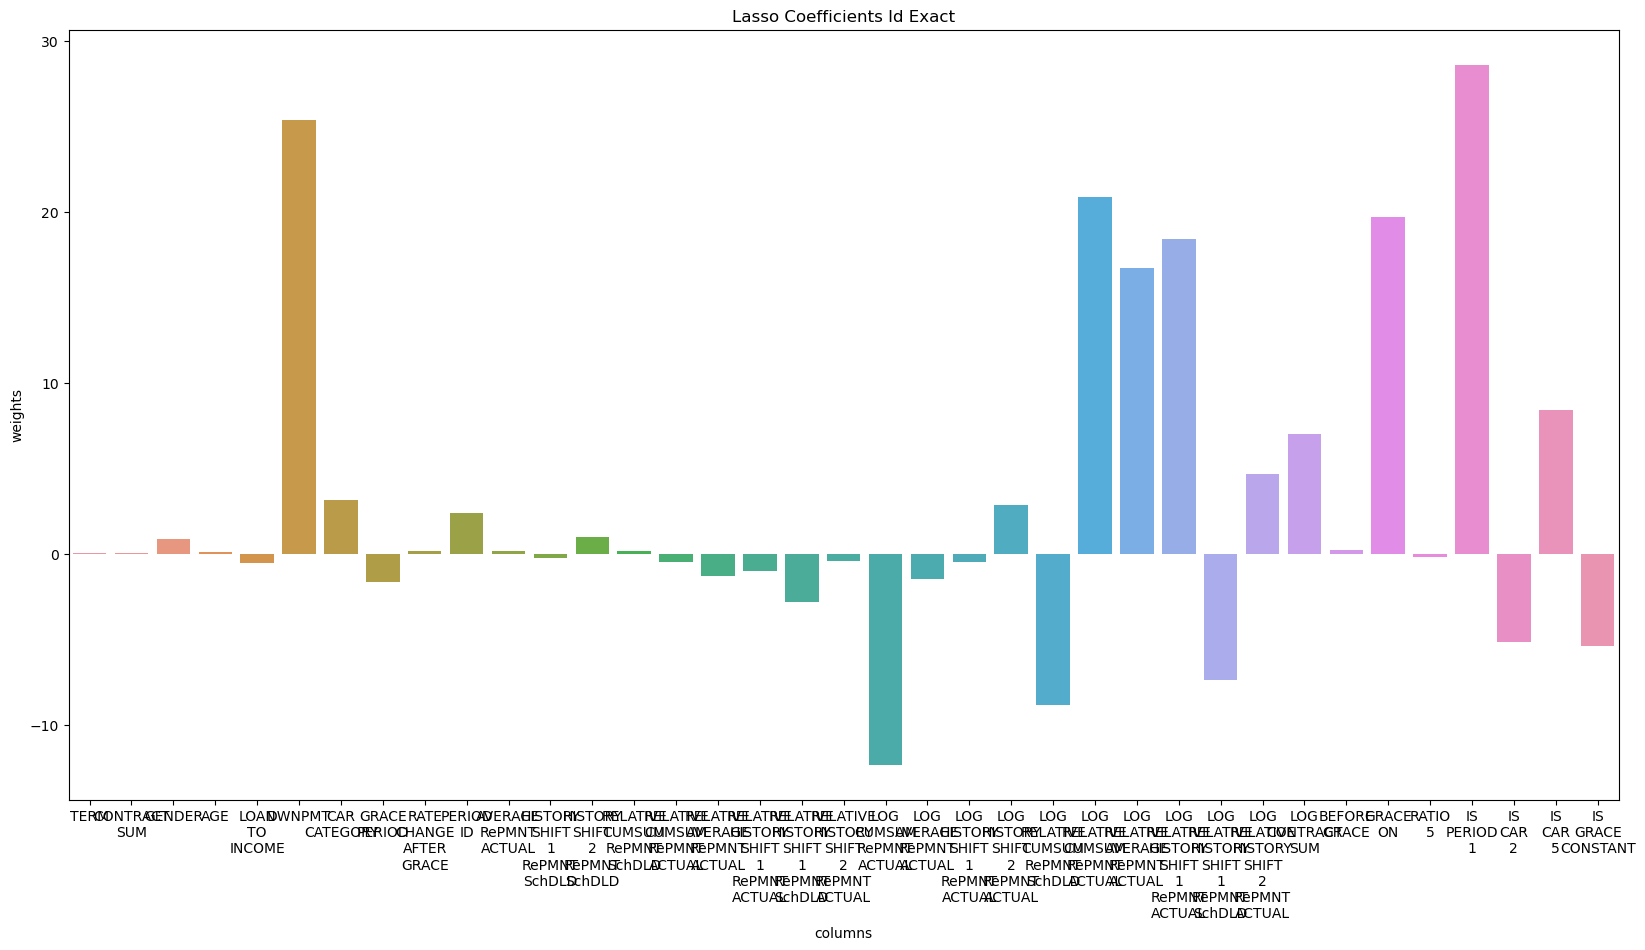

In [28]:
plot_linear_coefficients(
    X_train, percent_prediction_metrics.algo2estimator['lasso_regression_id_exact'], 
    "Lasso Coefficients Id Exact", shrink=0.01)

Plotting Ridge Regression (for exact and relative non-transformed target).

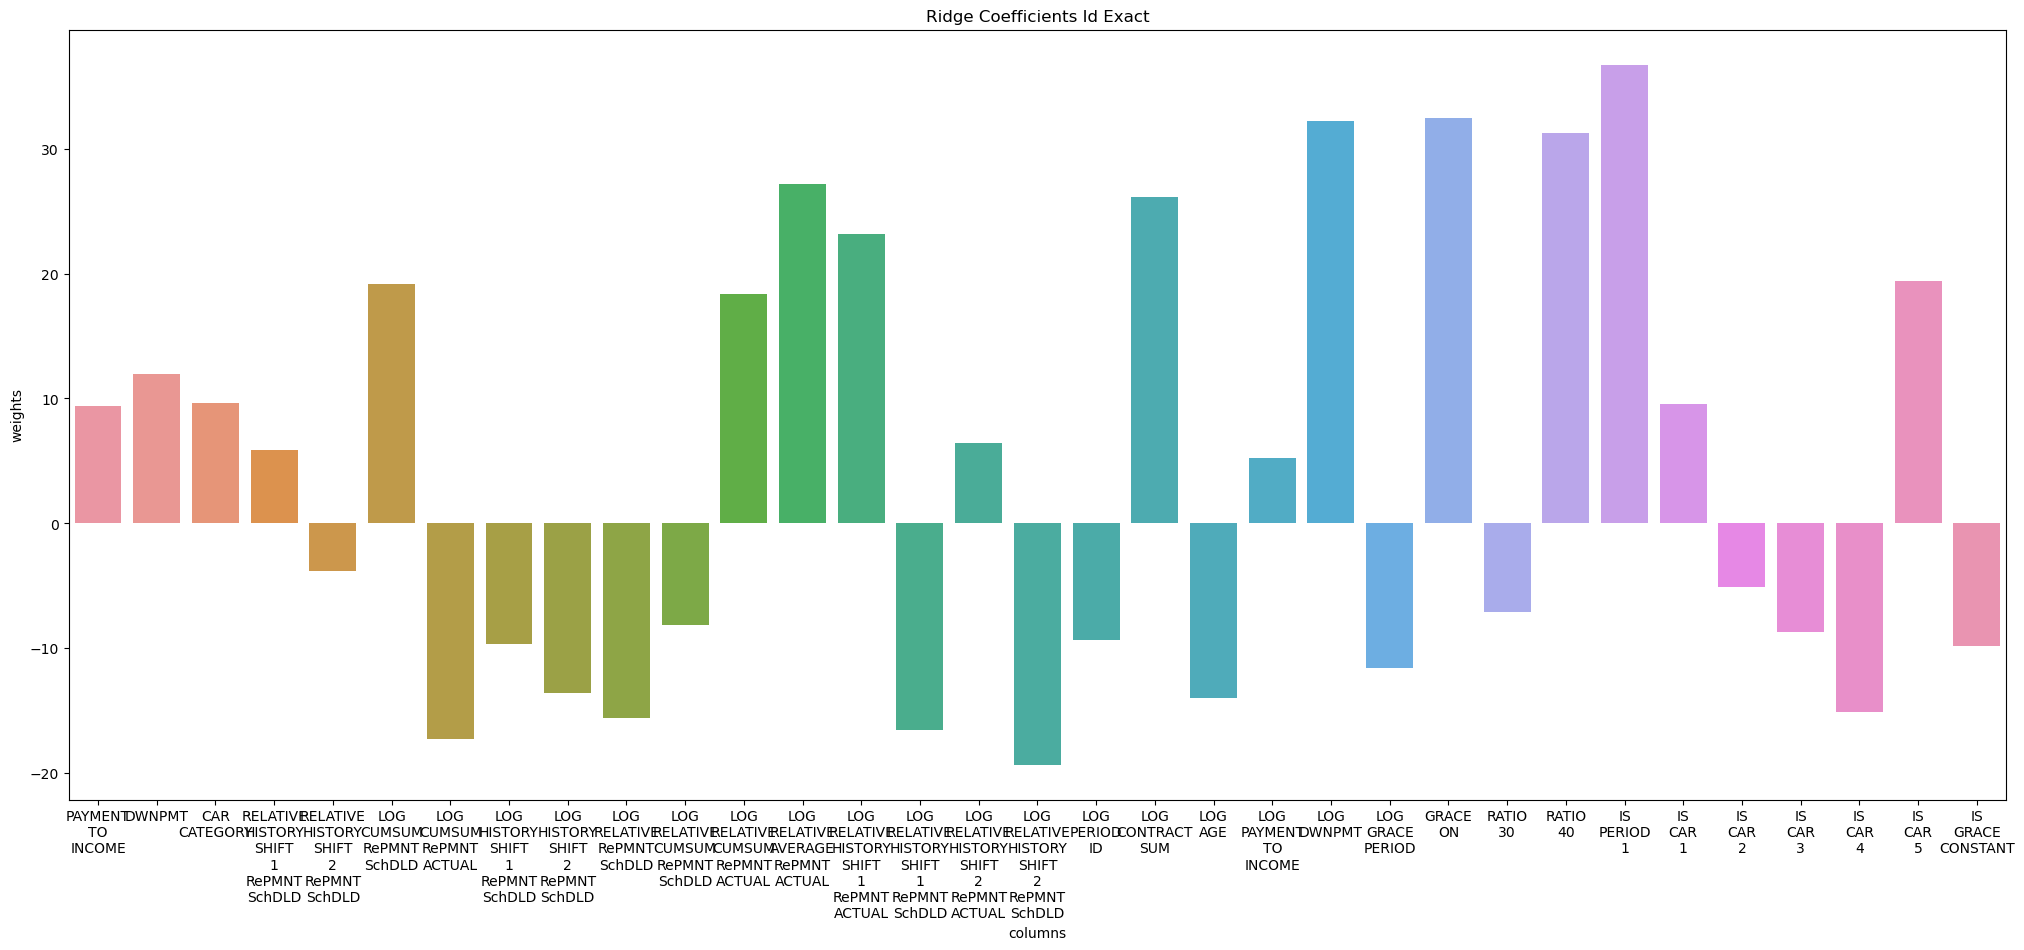

In [29]:
plot_linear_coefficients(
    X_train, percent_prediction_metrics.algo2estimator['ridge_regression_id_exact'],
    "Ridge Coefficients Id Exact", shrink=3.0, x_figure_shift=5)

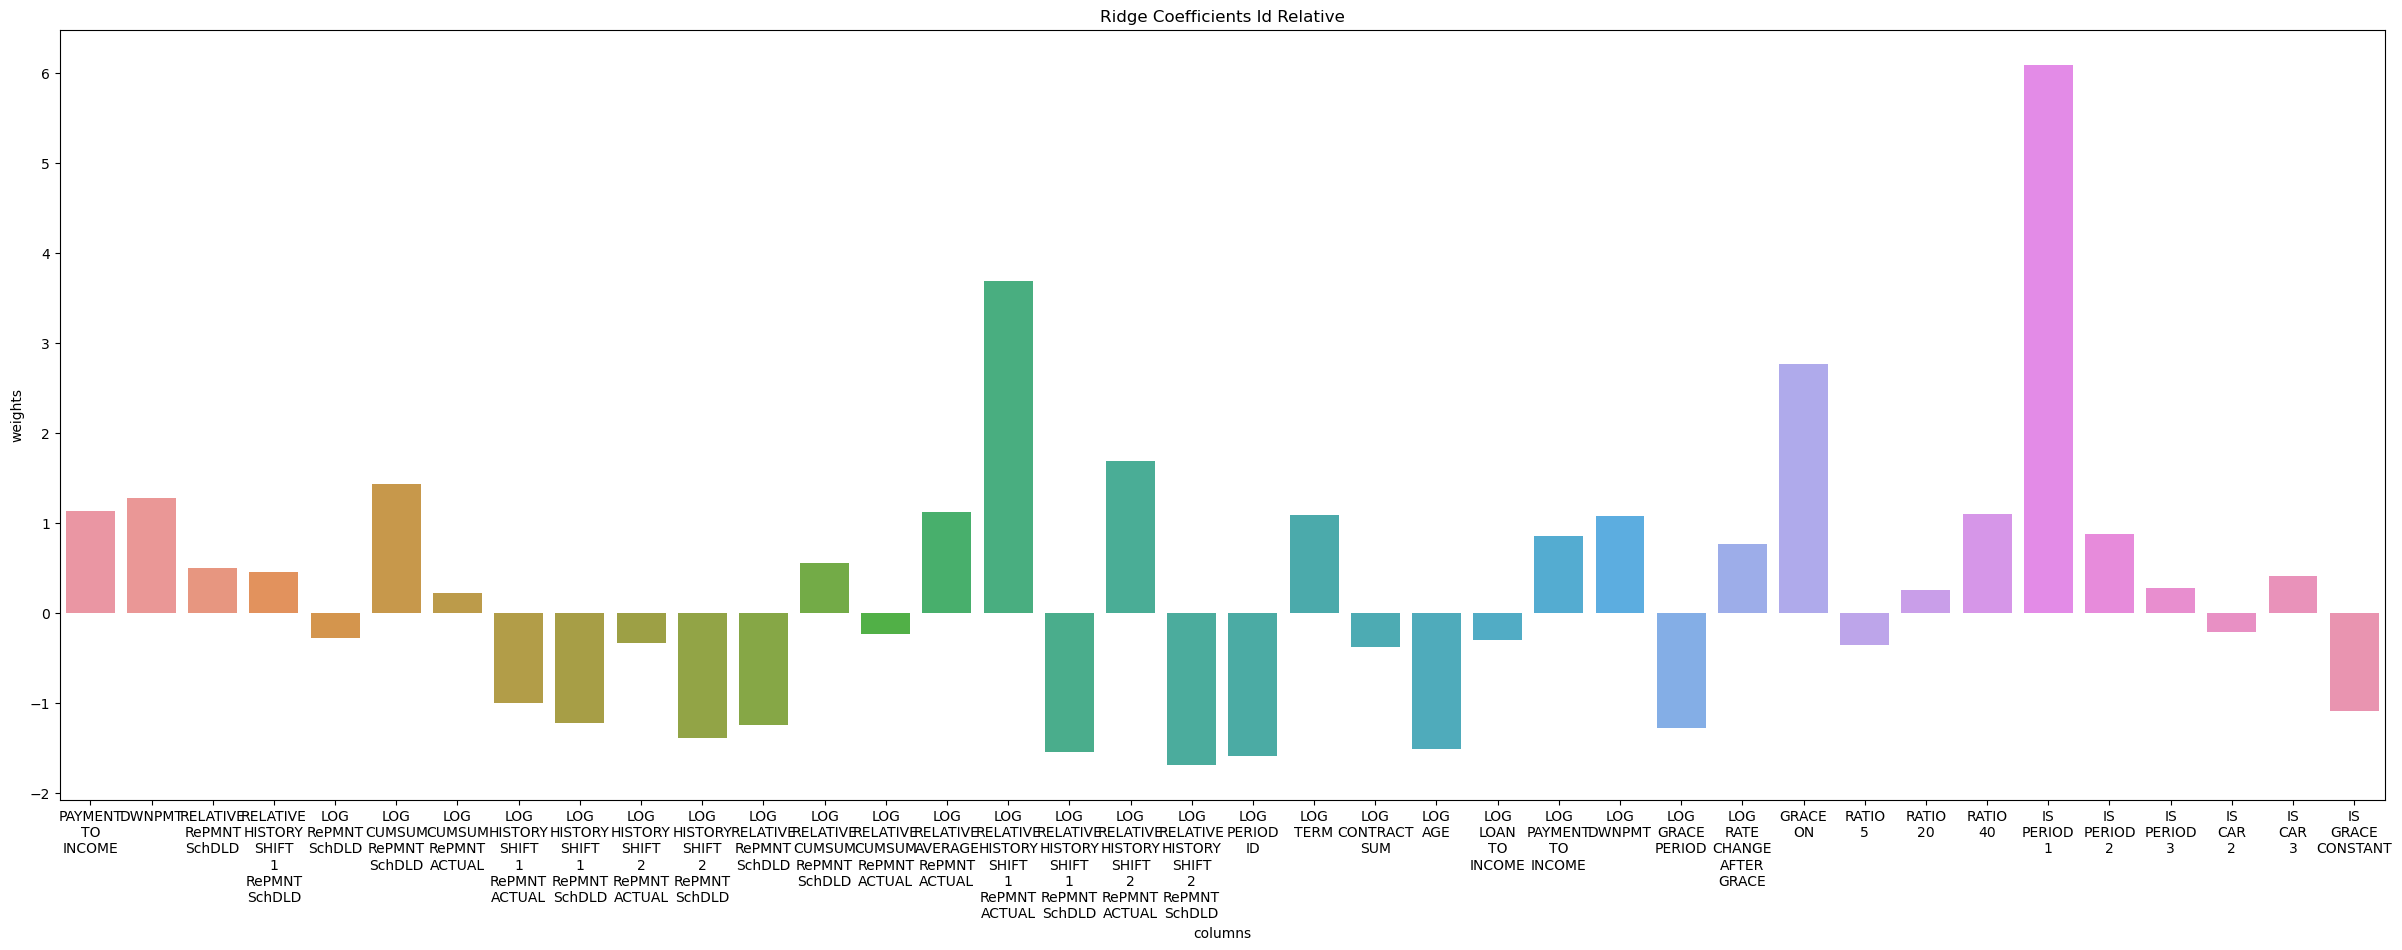

In [30]:
plot_linear_coefficients(
    X_train, percent_prediction_metrics.algo2estimator['ridge_regression_id_relative'],
    "Ridge Coefficients Id Relative", shrink=0.2, x_figure_shift=10)

Introduce a method to plot XGBoost feature importances.

In [31]:
from xgboost import plot_importance

def plot_xgboost_importances(xgboost_model: EstimatorType, title: str) -> None:
    """ Visualization of XGBoost feature importances.
    The plot is saved to images/regress directory.
    
    Arguments:
        xgboost_model: Learned xgboost estimator. 
        title: Title of the plot.
    """
    FIGURE_WIDTH: int = 14
    FIGURE_HEIGHT: int = 7
    FIGURE_DPI: int = 300
        
    plt.rcParams["figure.figsize"] = (FIGURE_WIDTH, FIGURE_HEIGHT)
    plot_importance(xgboost_model, height=0.2)
    plt.title(title)
    plt.savefig("images/regress/" + title.replace(" ", "_").lower() + ".png", dpi=FIGURE_DPI, bbox_inches='tight')


XGBoost feature importances, for log-exact and log-relative target.

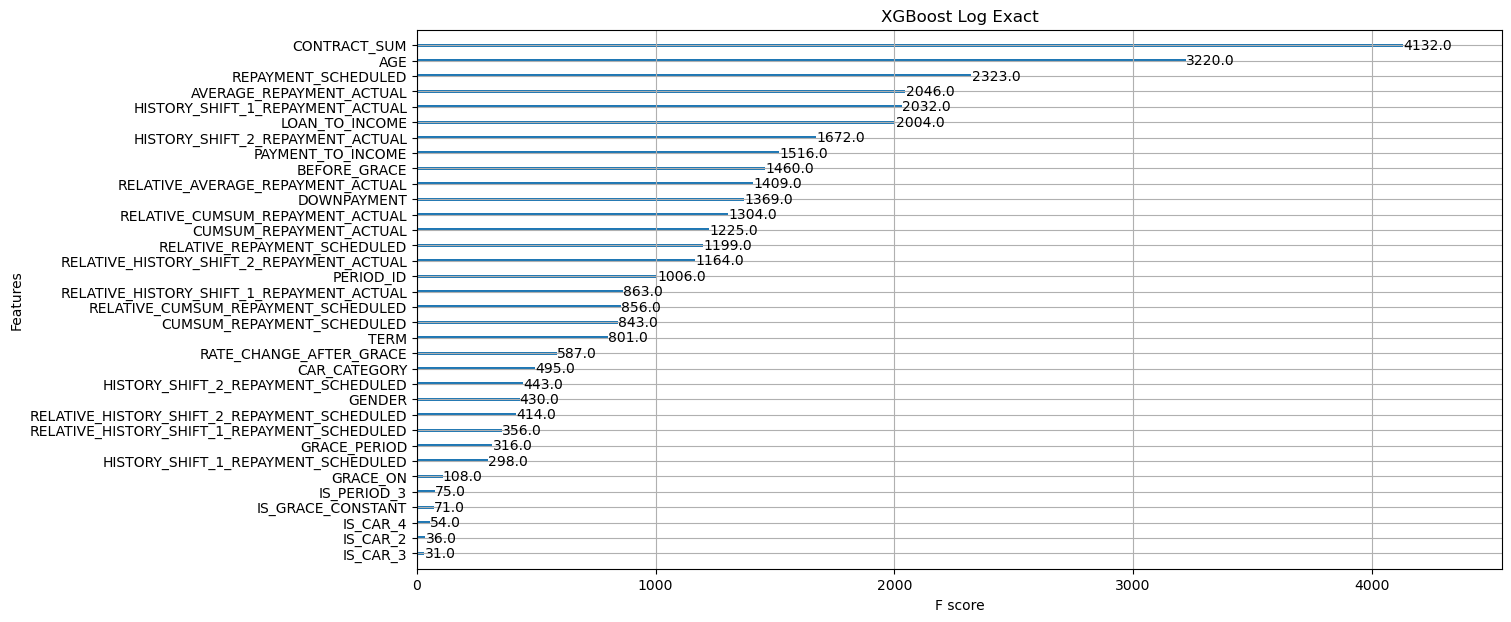

In [32]:
plot_xgboost_importances(percent_prediction_metrics.algo2estimator['xgboost_log_exact'], "XGBoost Log Exact")

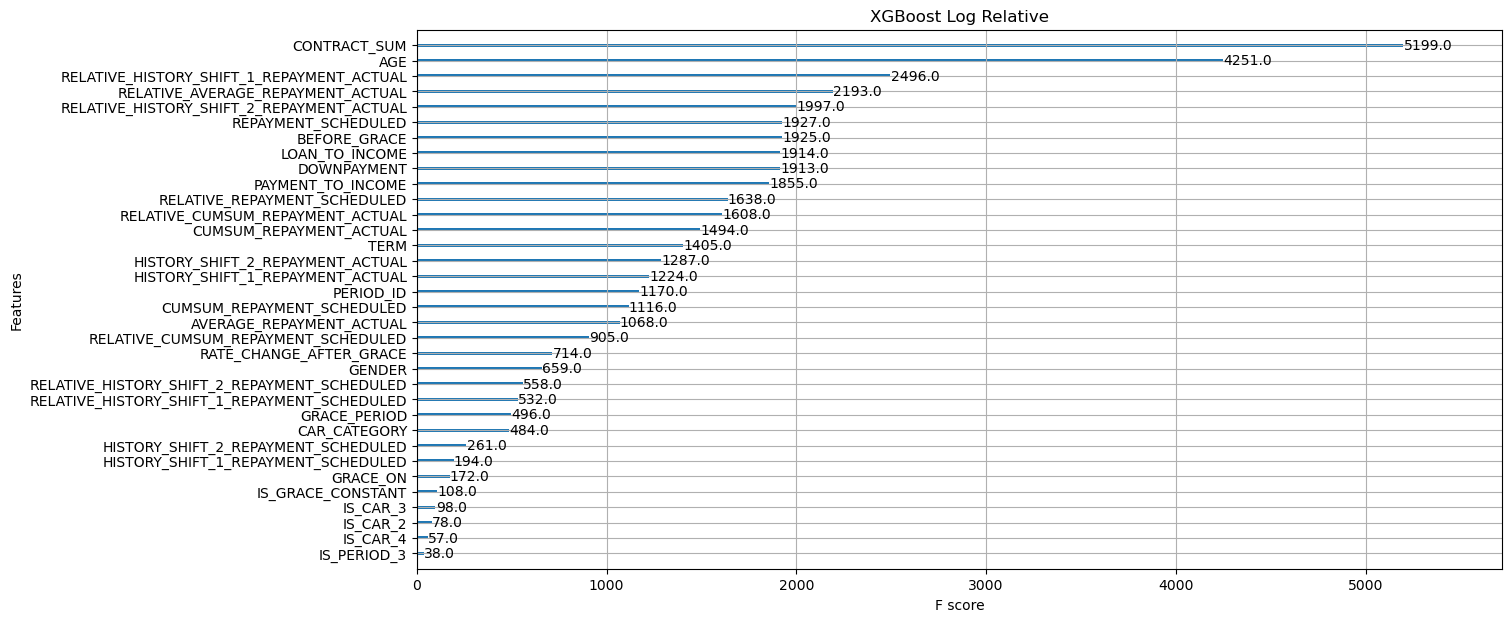

In [33]:
plot_xgboost_importances(percent_prediction_metrics.algo2estimator['xgboost_log_relative'], "XGBoost Log Relative")

Introduce a function to plot RandomForest feature importances.

In [34]:
import seaborn as sns

def plot_random_forest_importances(X_train: pd.DataFrame, rf_model: EstimatorType, 
                                   title: str, threshold: Optional[float]) -> None:
    """ Visualizes random forest feature importances.
    Saves the result to the images/regress/ directory.
    
    Arguments:
        X_train -- Train dataframe with features.
        rf_model -- Learned RF model.
        title -- Title of the plot.
        threshold -- Only features more important than threshold are 
            present on the plot. Ignored if threshold is None.
    """
    columns: List[str] = copy.deepcopy(X_train.columns).tolist()
        
    idx: int
    for idx in range(len(columns)):
        columns[idx] = columns[idx].replace("_", "\n")
        columns[idx] = columns[idx].replace("DOWNPAYMENT", "DWNPMT")
        columns[idx] = columns[idx].replace("REPAYMENT", "RePMNT")
        columns[idx] = columns[idx].replace("SCHEDULED", "SchDLD")
        
    df: pd.DataFrame = pd.DataFrame.from_dict({
        'importance' : rf_model.feature_importances_,
        'feature'     : columns
    })
    if threshold is not None:
        df = df[df['importance'] > threshold]
    df = df.sort_values(by='importance', ascending=False)
    
    FIGURE_WIDTH: int = 35
    FIGURE_HEIGHT: int = 5
    FIGURE_DPI: int = 300
        
    plt.figure(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))
    sns.barplot(data=df, x='feature', y='importance')
    plt.title(title)
    plt.savefig("images/regress/" + title.replace(" ", "_").lower() + ".png", dpi=FIGURE_DPI, bbox_inches='tight')

Visualize RandomForest feature importances, for log-exact and log-relative target.

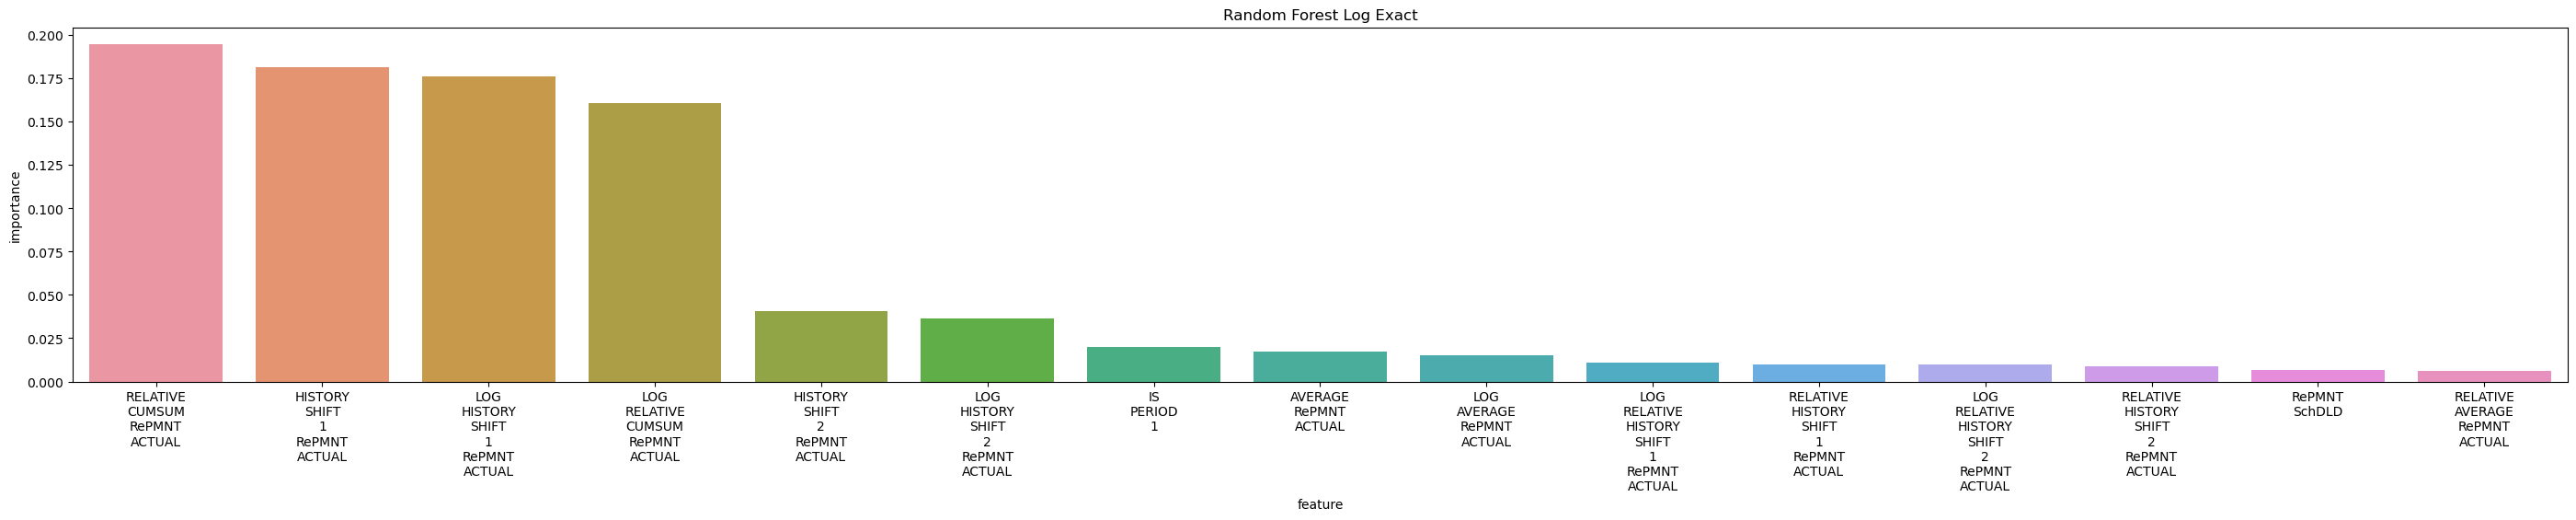

In [35]:
plot_random_forest_importances(
    X_train, percent_prediction_metrics.algo2estimator['random_forest_log_exact'], 
    "Random Forest Log Exact", threshold=0.006)

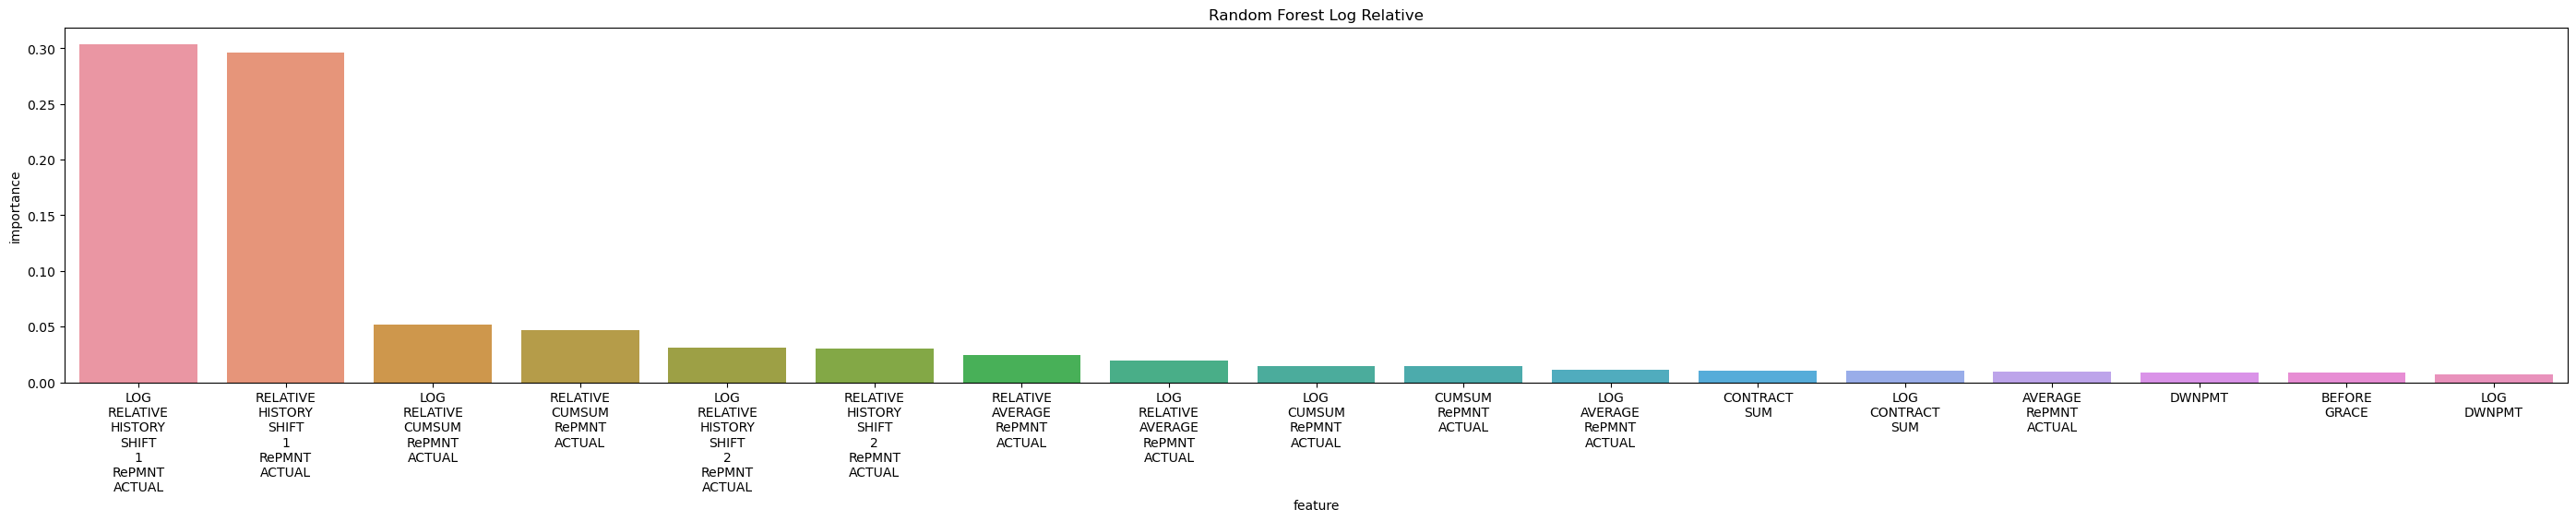

In [36]:
plot_random_forest_importances(
    X_train, percent_prediction_metrics.algo2estimator['random_forest_log_relative'], 
    "Random Forest Log Relative", threshold=0.007)

Saving the best performing algorithm for relative series completion.

In [37]:
best_rf: EstimatorType = value_prediction_metrics.algo2estimator['random_forest_log_relative']
best_rf.fit(X_all, y_all_log_relative)
joblib.dump(best_rf, 'algorithms/rf-log-relative.jbl')

['algorithms/rf-log-relative.jbl']